# Инференс модели предсказания изменения ландшафта на спутниковых снимках

Импортируем требуемые зависимости

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torch import nn
from torchvision import transforms
from tqdm.notebook import tqdm

from torch.utils.data import DataLoader, Dataset
from PIL import Image

from diffusers import DDPMScheduler, UNet2DModel, UNet2DConditionModel
from utils import match_histograms, extract_patches, show_images, unfold_batch_n_times
from esrgan import Generator

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


Загрузим исходные изображения

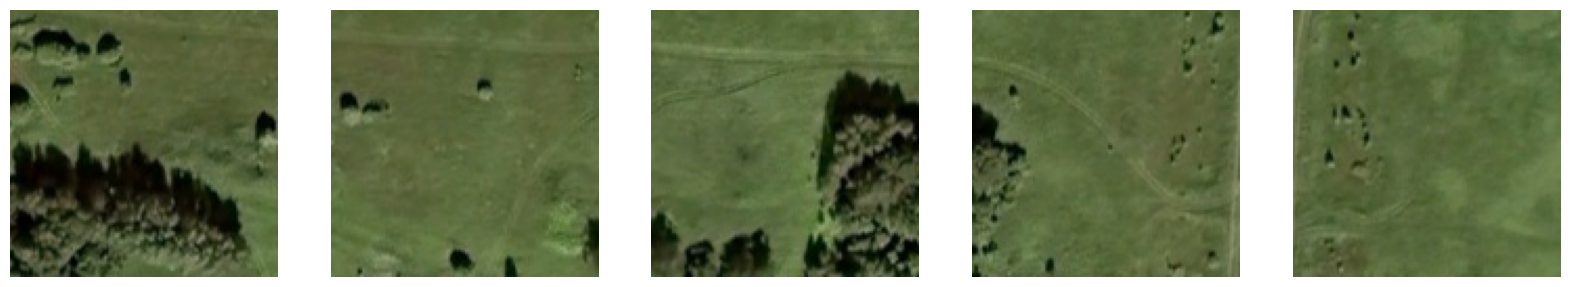

In [3]:
image_from = cv2.imread('./images/1_2014_7.jpg')
image_from = cv2.cvtColor(image_from, cv2.COLOR_BGR2RGB)
patches = extract_patches(Image.fromarray(image_from), 128, 128, 128 * 42)
show_images(patches.cpu()[0:5])

Загрузим esrgan-модель для увеличения разрешения

In [ ]:
generator = Generator(in_channels=3, num_blocks=23, weights='generator_32_to_128').to(device)
generator.eval()

Создадим unet-модель и инициализируем весами

In [5]:
class ClassConditionedUnet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = UNet2DModel(
            sample_size=32,
            in_channels=51,
            out_channels=3,
            layers_per_block=2,
            block_out_channels=(224, 448, 672, 896),
            down_block_types=("AttnDownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D"),
            up_block_types=("AttnUpBlock2D", "AttnUpBlock2D", "AttnUpBlock2D", "AttnUpBlock2D"),
        )

    def forward(self, x, t, base):
        bs, ch, w, h = x.shape
        net_input = torch.cat((x, base), 1)
        return self.model(net_input, t).sample

In [ ]:
net = ClassConditionedUnet().to(device)
net.load_state_dict(torch.load('./unet_weights_32'))
net.eval()

Объявим функция для генерации предсказания

In [7]:
def generate_image(img, base):
    x = torch.randn_like(img.float()).to(device)
    for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
        with torch.no_grad():
            residual = net(x, t, unfold_batch_n_times(base, 2).to(device))
        x = noise_scheduler.step(residual, t, x).prev_sample
    return x

In [8]:
noise_scheduler = DDPMScheduler(num_train_timesteps=100, beta_schedule='squaredcos_cap_v2')

In [9]:
patches_32 = transforms.Resize((32, 32), antialias=True)(patches.permute(0, 3, 1, 2)[0:5])
patches_128 = transforms.Resize((128, 128), antialias=True)(patches.permute(0, 3, 1, 2)[0:5])

images_32 = []
images_128 = []

images_32.append(patches_32 / 255)
images_128.append(patches_128 / 255)

Выполним генерацию один раз

In [10]:
images_32.append(images_32[-1] + generate_image(images_32[-1], images_128[-1]).cpu())
images_128.append(generator(images_32[-1].to(device)).detach())

0it [00:00, ?it/s]

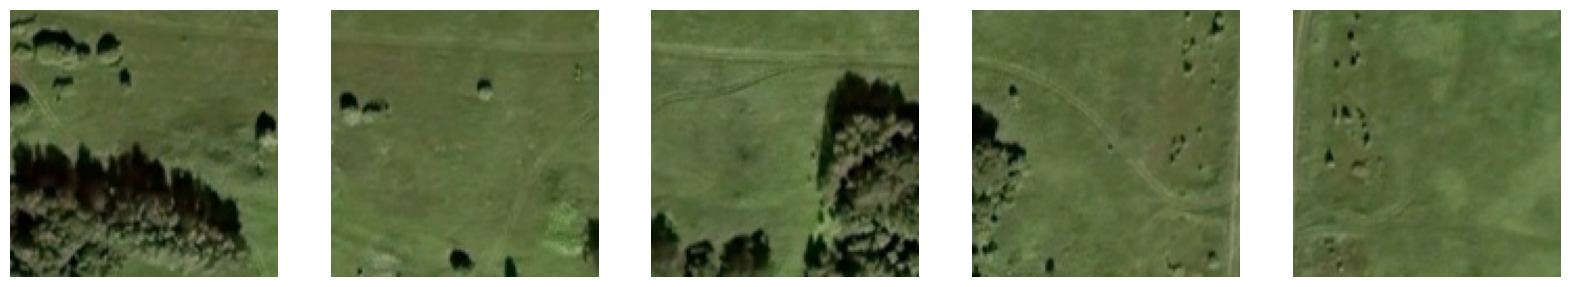

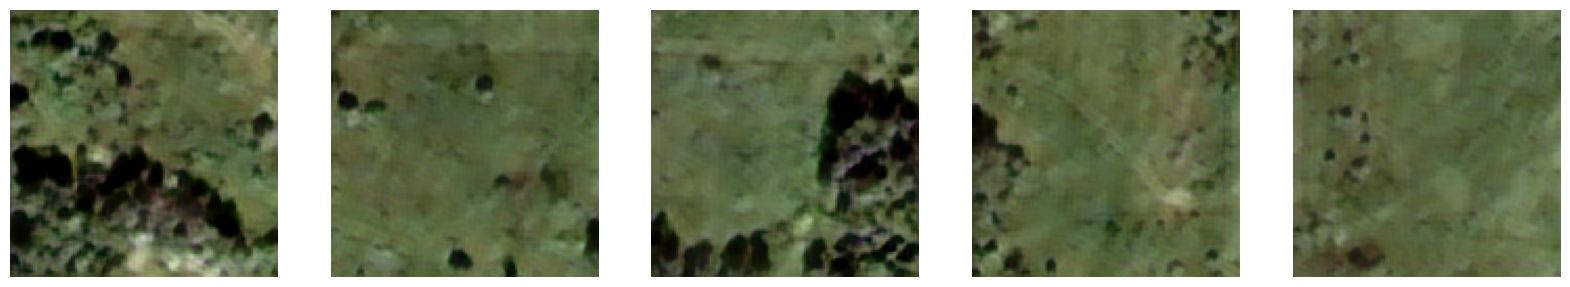

In [11]:
for image in images_128:
    show_images(image.permute(0, 2, 3, 1).cpu().clip(0,1))

Выполним генерацию снова, взяв за основу изображение, полученное на предыдущем шаге

In [12]:
images_32.append(images_32[-1] + generate_image(images_32[-1], images_128[-1]).cpu())
images_128.append(generator(images_32[-1].to(device)).detach())

0it [00:00, ?it/s]

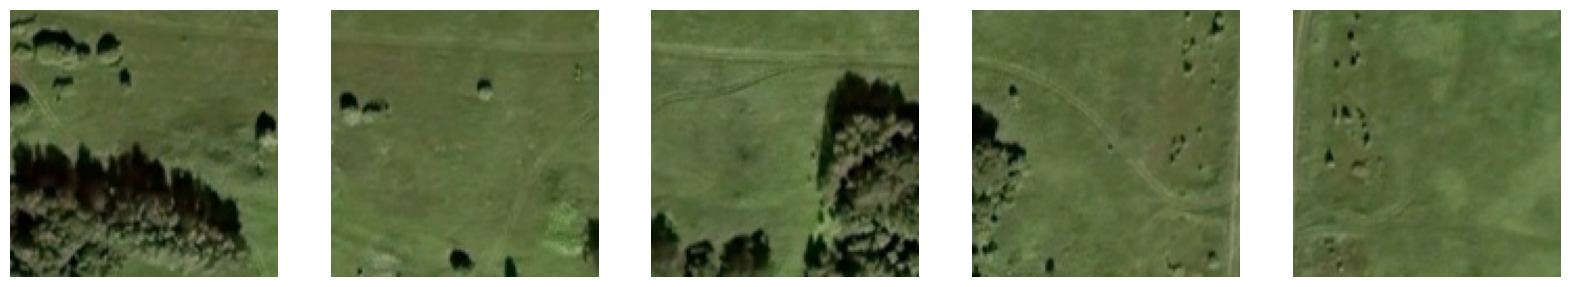

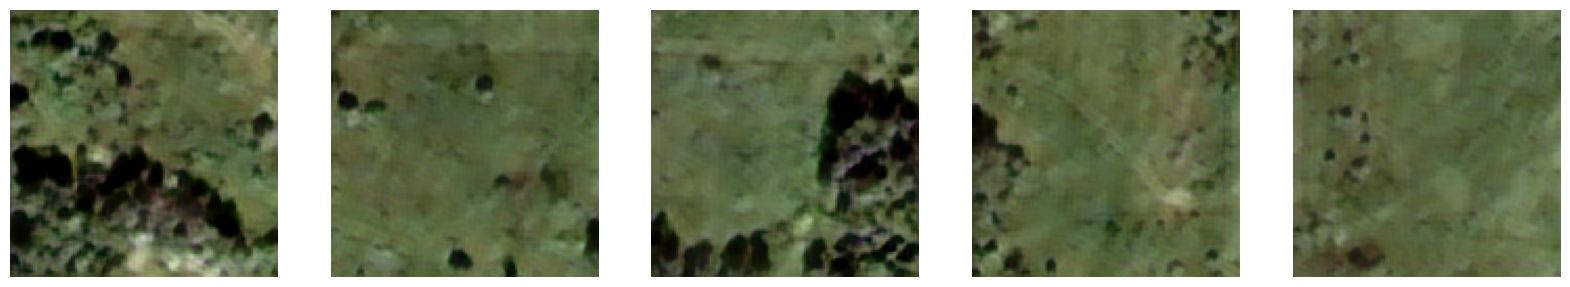

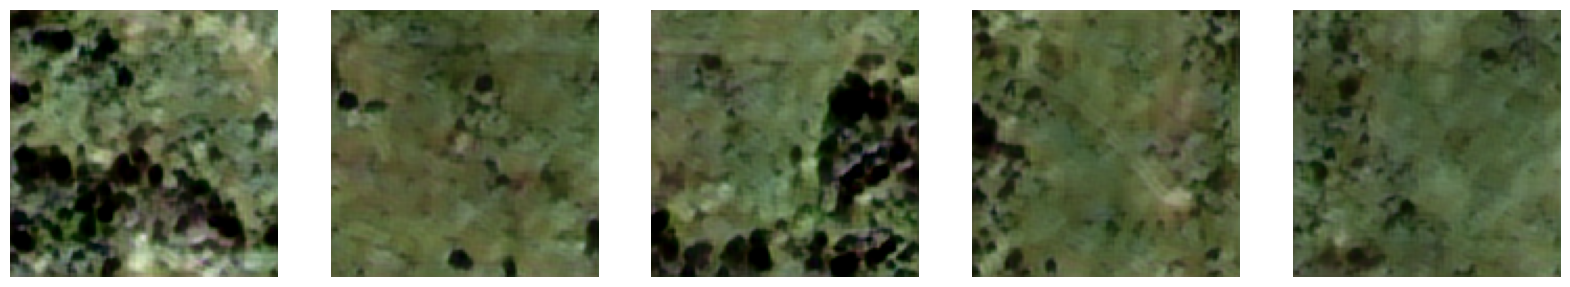

In [13]:
for image in images_128:
    show_images(image.permute(0, 2, 3, 1).cpu().clip(0,1))

И еще раз

In [14]:
images_32.append(images_32[-1] + generate_image(images_32[-1], images_128[-1]).cpu())
images_128.append(generator(images_32[-1].to(device)).detach())

0it [00:00, ?it/s]

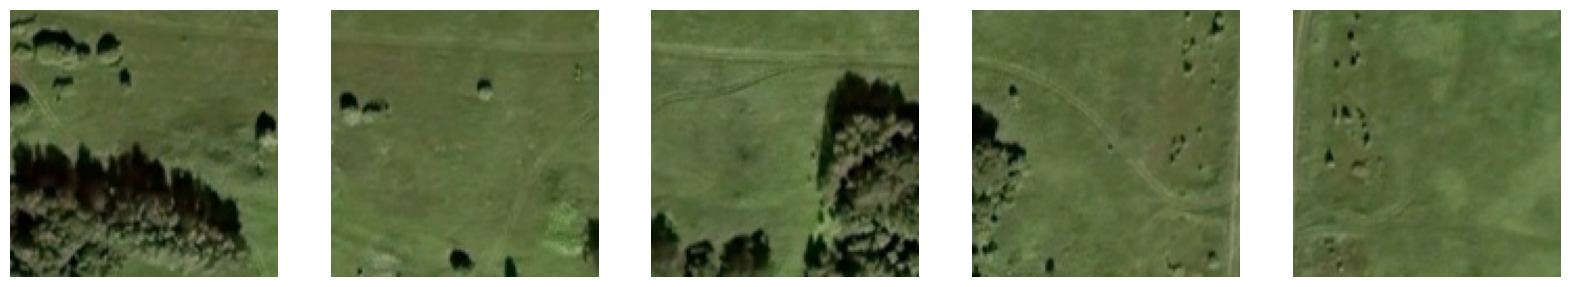

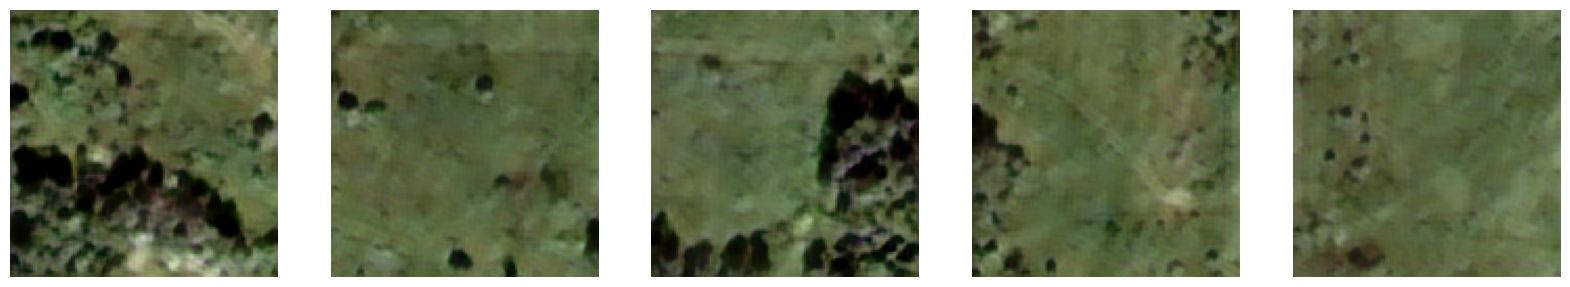

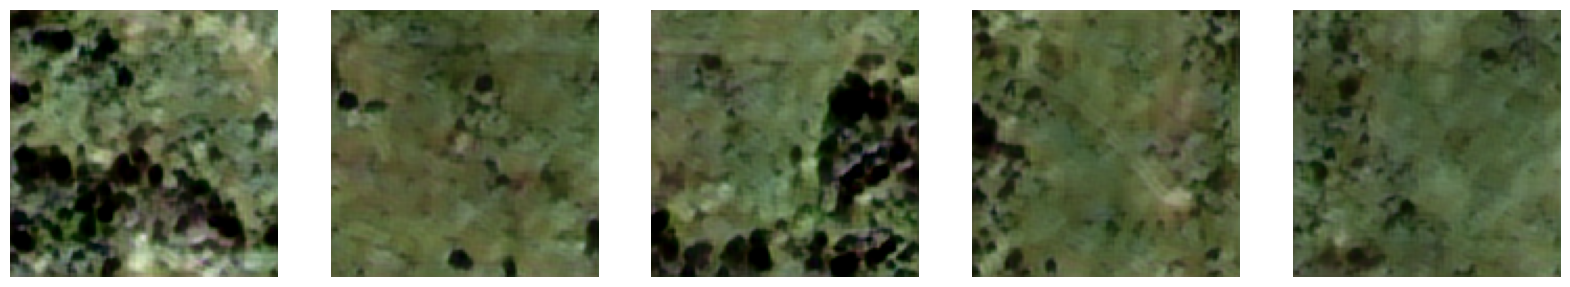

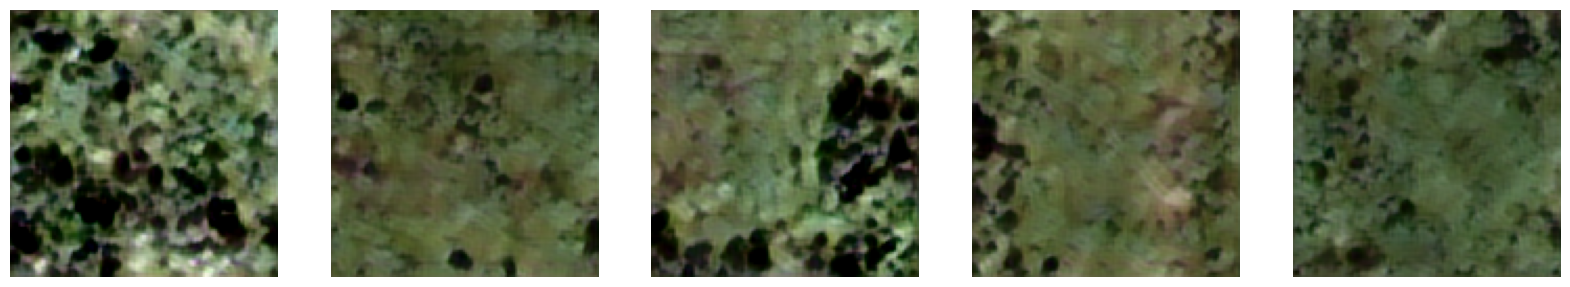

In [15]:
for image in images_128:
    show_images(image.permute(0, 2, 3, 1).cpu().clip(0,1))

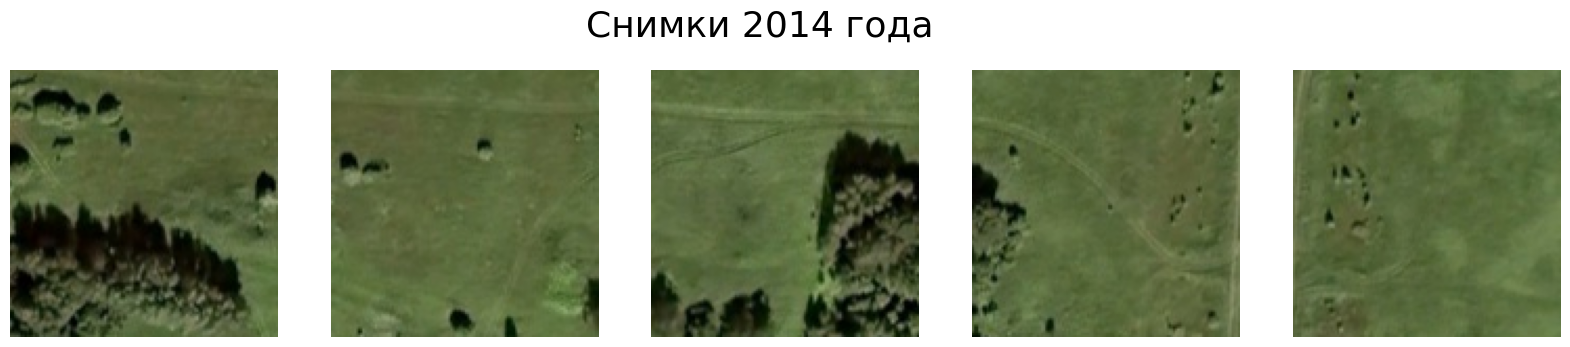

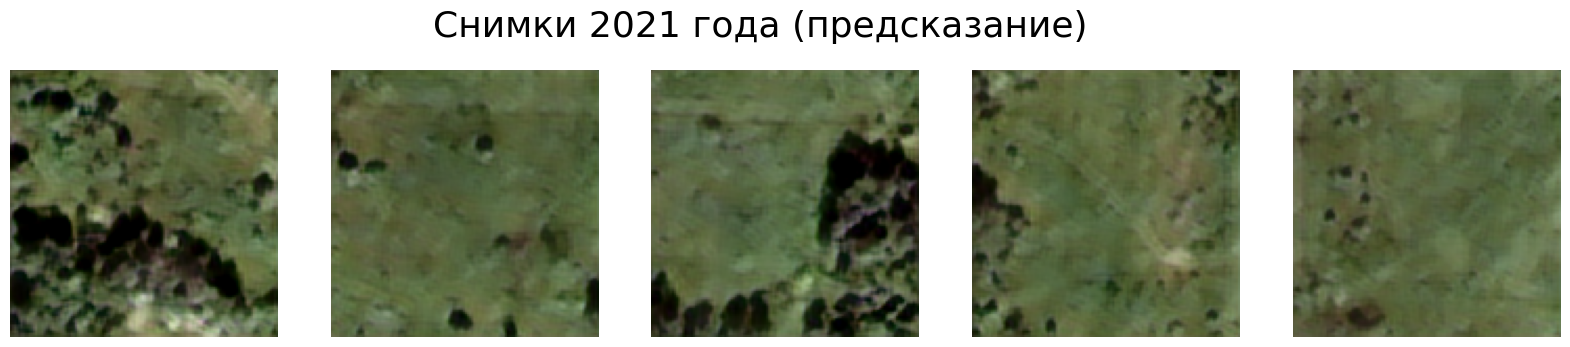

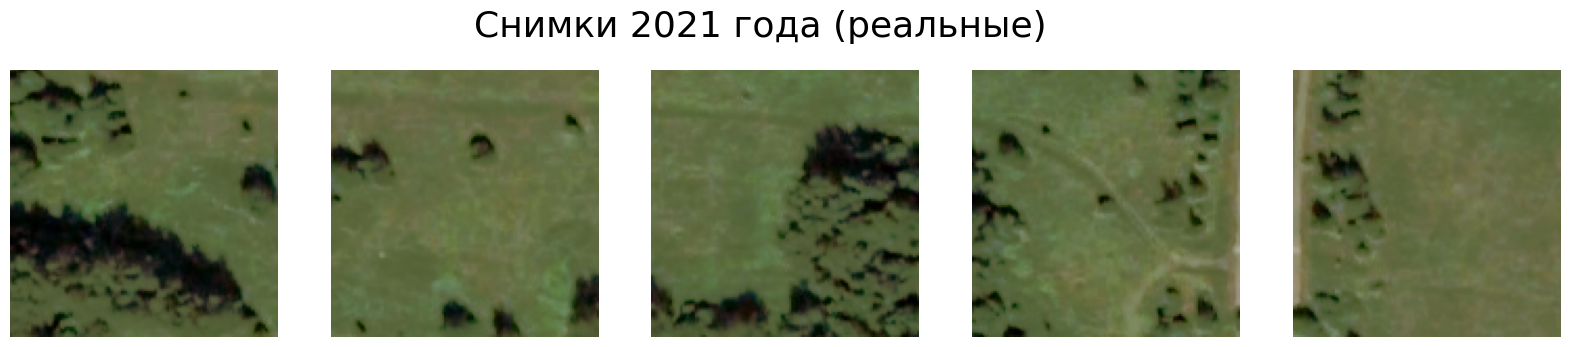

In [17]:
show_images(images_128[0].permute(0, 2, 3, 1).cpu().clip(0,1), title='Снимки 2014 года')
show_images(images_128[1].permute(0, 2, 3, 1).cpu().clip(0,1), title='Снимки 2021 года (предсказание)')

image_to = cv2.imread('./images/1_2021_7.jpg')
image_to = cv2.cvtColor(image_to, cv2.COLOR_BGR2RGB)
image_from, image_to = match_histograms(image_from, image_to)
patches_to = extract_patches(Image.fromarray(image_to), 128, 128, 128 * 42)
patches_to = patches_to.permute(0, 3, 1, 2)[0:5]
show_images(patches_to.permute(0, 2, 3, 1).cpu()[0:5], title='Снимки 2021 года (реальные)')
